In [20]:
import torch

print("PyTorch Version : {}".format(torch.__version__))

PyTorch Version : 1.9.0


In [21]:
import torchtext

print("TorchText Version : {}".format(torchtext.__version__))

TorchText Version : 0.10.0


In [22]:
from torch.utils.data import DataLoader

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()


In [23]:
import pandas as pd
train_df=pd.DataFrame(train_dataset)


In [24]:
train_df.head()

,0,1
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [25]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([train_dataset, test_dataset]), min_freq=1, specials=["<UNK>"])

vocab.set_default_index(vocab["<UNK>"])

In [26]:
len(vocab)

25271

In [27]:
tokens = tokenizer("Hello how are you?, Welcome to CoderzColumn!!")
indexes = vocab(tokens)

tokens, indexes

(['hello',
  'how',
  'are',
  'you',
  '?',
  ',',
  'welcome',
  'to',
  'coderzcolumn',
  '!',
  '!'],
 [11397, 337, 41, 174, 82, 3, 3015, 4, 0, 585, 585])

#### Approach 1: Single RNN Layer (Tokens Per Text Example=25, Embeddings Length=50) 

In [28]:
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset  = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

target_classes = ["World", "Sports", "Business", "Sci/Tech"]

max_words = 25

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.

    return torch.tensor(X, dtype=torch.int32), torch.tensor(Y) - 1 ## We have deducted 1 from target names to get them in range [0,1,2,3] from [1,2,3,4]


train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=vectorize_batch)

In [29]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 25]) torch.Size([1024])


Define RNN Classification Network

In [30]:
from torch import nn
from torch.nn import functional as F

embed_len = 50
hidden_dim = 50
n_layers=1

class RNNClassifier(nn.Module):
    def __init__(self):
        super(RNNClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.rnn = nn.RNN(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings, torch.randn(n_layers, len(X_batch), hidden_dim))
        return self.linear(output[:,-1])


In [31]:
rnn_classifier = RNNClassifier()

rnn_classifier

RNNClassifier(
  (embedding_layer): Embedding(25271, 50)
  (rnn): RNN(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)

In [32]:
for layer in rnn_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(25271, 50)
Parameters : 
torch.Size([25271, 50])

Layer : RNN(50, 50, batch_first=True)
Parameters : 
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])

Layer : Linear(in_features=50, out_features=4, bias=True)
Parameters : 
torch.Size([4, 50])
torch.Size([4])



In [33]:
out = rnn_classifier(torch.randint(0, len(vocab), (1024, max_words)))

out.shape

torch.Size([1024, 4])

In [34]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)

In [35]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

TrainModel(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|█████████████████████████████████████████| 118/118 [00:12<00:00,  9.77it/s]


Train Loss : 1.313
Valid Loss : 1.141
Valid Acc  : 0.504


100%|█████████████████████████████████████████| 118/118 [00:13<00:00,  8.81it/s]


Train Loss : 0.929
Valid Loss : 0.775
Valid Acc  : 0.703


100%|█████████████████████████████████████████| 118/118 [00:14<00:00,  8.26it/s]


Train Loss : 0.662
Valid Loss : 0.621
Valid Acc  : 0.770


100%|█████████████████████████████████████████| 118/118 [00:17<00:00,  6.89it/s]


Train Loss : 0.538
Valid Loss : 0.541
Valid Acc  : 0.806


100%|█████████████████████████████████████████| 118/118 [00:25<00:00,  4.67it/s]


Train Loss : 0.466
Valid Loss : 0.497
Valid Acc  : 0.827


100%|█████████████████████████████████████████| 118/118 [00:18<00:00,  6.33it/s]


Train Loss : 0.420
Valid Loss : 0.454
Valid Acc  : 0.843


100%|█████████████████████████████████████████| 118/118 [00:26<00:00,  4.54it/s]


Train Loss : 0.387
Valid Loss : 0.432
Valid Acc  : 0.851


100%|█████████████████████████████████████████| 118/118 [00:17<00:00,  6.79it/s]


Train Loss : 0.362
Valid Loss : 0.431
Valid Acc  : 0.854


100%|█████████████████████████████████████████| 118/118 [00:17<00:00,  6.64it/s]


Train Loss : 0.339
Valid Loss : 0.403
Valid Acc  : 0.864


100%|█████████████████████████████████████████| 118/118 [00:19<00:00,  6.07it/s]


Train Loss : 0.322
Valid Loss : 0.397
Valid Acc  : 0.868


100%|█████████████████████████████████████████| 118/118 [00:24<00:00,  4.91it/s]


Train Loss : 0.305
Valid Loss : 0.394
Valid Acc  : 0.870


100%|█████████████████████████████████████████| 118/118 [00:22<00:00,  5.21it/s]


Train Loss : 0.292
Valid Loss : 0.392
Valid Acc  : 0.873


100%|█████████████████████████████████████████| 118/118 [00:24<00:00,  4.88it/s]


Train Loss : 0.280
Valid Loss : 0.382
Valid Acc  : 0.874


100%|█████████████████████████████████████████| 118/118 [00:24<00:00,  4.77it/s]


Train Loss : 0.268
Valid Loss : 0.383
Valid Acc  : 0.876


100%|█████████████████████████████████████████| 118/118 [00:20<00:00,  5.70it/s]


Train Loss : 0.260
Valid Loss : 0.379
Valid Acc  : 0.877


Evaluate Network Performance

In [36]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(rnn_classifier, test_loader)


In [37]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))


Test Accuracy : 0.8756578947368421

Classification Report : 
              precision    recall  f1-score   support

       World       0.88      0.88      0.88      1900
      Sports       0.92      0.95      0.94      1900
    Business       0.86      0.83      0.84      1900
    Sci/Tech       0.84      0.84      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600


Confusion Matrix : 
[[1671   68   77   84]
 [  42 1806   23   29]
 [  85   42 1574  199]
 [  93   37  166 1604]]


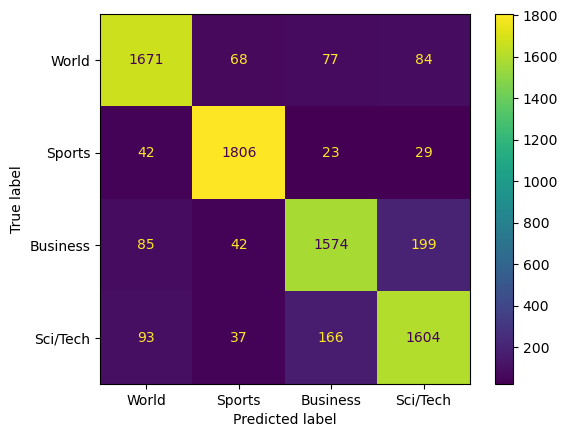

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm_display = ConfusionMatrixDisplay(confusion_matrix(Y_actual, Y_preds),display_labels=target_classes)
cm_display.plot()
plt.show()

In [48]:
X_test_text, Y_test = [], []
for Y, X in test_dataset:
    X_test_text.append(X)
    Y_test.append(Y-1)

len(X_test_text)

7600

In [49]:
def make_predictions(X_batch_text):
    X = [vocab(tokenizer(text)) for text in X_batch_text]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
    logits = rnn_classifier(torch.tensor(X, dtype=torch.int32))
    preds = F.softmax(logits, dim=-1)
    return preds.detach().numpy()

rng = np.random.RandomState(1)
idx = rng.randint(1, len(X_test_text))
X = [vocab(tokenizer(text)) for text in X_test_text[idx:idx+1]]
X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
preds = rnn_classifier(torch.tensor(X, dtype=torch.int32))
preds = F.softmax(preds, dim=-1)

print("Prediction : ", target_classes[preds.argmax()])
print("Actual :     ", target_classes[Y_test[idx]])

Prediction :  Business
Actual :      Business
